### Project Fletcher Airline Sentiment Analysis

In [1]:
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pylab
%matplotlib inline

from nltk.corpus import twitter_samples
from nltk.tokenize.casual import TweetTokenizer

from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, confusion_matrix

##### Define Preprocessing and Tokenizer Functions to Read into Vectorizer

In [2]:
def preprocess(text):
    text = re.sub(r"(?:\https?\://)\S+", "", text) #remove urls
    text = re.sub('\@(\w+)', " ", text).replace(": ","") #remove usernames
    text = re.sub('#(\w+)', " ", text) #remove hashtags
    text = text.replace("RT ","") #remove RT Symbols
    text = text.replace("RT: ","") #remove RT Symbols
    text = re.sub("[^a-zA-Z,]+", " ", text) #remove other non-alpha characters
    text = text.strip(" ") #remove leading and trailing whitespace
    
    return text

def tokenize(text):
    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)  
    
    return [x for x in tokenizer.tokenize(preprocess(text)) if len(x)>=4]

#### Read-In NLTK Twitter Sentiment Data

In [3]:
def read_demo_tweets():
    tweets = []
    for tweet in twitter_samples.strings("negative_tweets.json"):
        tweets.append({"text":tweet, "sentiment":1})
        
    for tweet in twitter_samples.strings("positive_tweets.json"):
        tweets.append({"text":tweet, "sentiment":0})
        
    return pd.DataFrame(tweets)


demo_tweets=read_demo_tweets()
print demo_tweets.sentiment.value_counts(dropna=False)
demo_tweets.head(5)

1    5000
0    5000
Name: sentiment, dtype: int64


,sentiment,text
0,1,hopeless for tmr :(
1,1,Everything in the kids section of IKEA is so c...
2,1,@Hegelbon That heart sliding into the waste ba...
3,1,"“@ketchBurning: I hate Japanese call him ""bani..."
4,1,"Dang starting next week I have ""work"" :("


#### Read in CrowdFlower Data. Split Unambigous Tweets into Train and Test

In [4]:
cf = pd.read_pickle("data/crowdflower/airline_sentiment_with_tb_vader.pkl")
cf.head(5)

,_unit_id,_trusted_judgments,airline_sentiment:confidence,airline,text,sentiment,text_blob_sentiment,vader_sentiment
0,681448150,3,1.0000,Virgin America,@VirginAmerica What @dhepburn said.,0,0.000000,0.0000
1,681448153,3,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...,0,0.000000,0.0000
2,681448156,3,0.6837,Virgin America,@VirginAmerica I didn't today... Must mean I n...,0,-0.390625,0.0000
3,681448158,3,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...,1,0.006250,-0.5984
4,681448159,3,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...,1,-0.350000,-0.5829


In [5]:
print cf.text_blob_sentiment.describe()
print cf.vader_sentiment.describe()

count    14640.000000
mean         0.048714
std          0.325888
min         -1.000000
25%         -0.010000
50%          0.000000
75%          0.200000
max          1.000000
Name: text_blob_sentiment, dtype: float64
count    14640.000000
mean         0.055417
std          0.456556
min         -0.966800
25%         -0.296000
50%          0.000000
75%          0.440400
max          0.976000
Name: vader_sentiment, dtype: float64


In [6]:
cf_unambig = cf.ix[(cf["_trusted_judgments"]>2) & (cf["airline_sentiment:confidence"]==1.00)]
cf_ambig = cf.ix[(cf["_trusted_judgments"]>2) & (cf["airline_sentiment:confidence"]<1.00)]

cf_train, cf_test = train_test_split(cf_unambig, test_size=0.3, random_state=4444)

print cf_ambig.shape, cf_unambig.shape, cf_train.shape, cf_test.shape

(4194, 8) (10427, 8) (7298, 8) (3129, 8)


#### Graph Positive/ Neutral vs. Negative Ratings by Airline

['Virgin America', 'Delta', 'Southwest', 'American', 'US Airways', 'United']


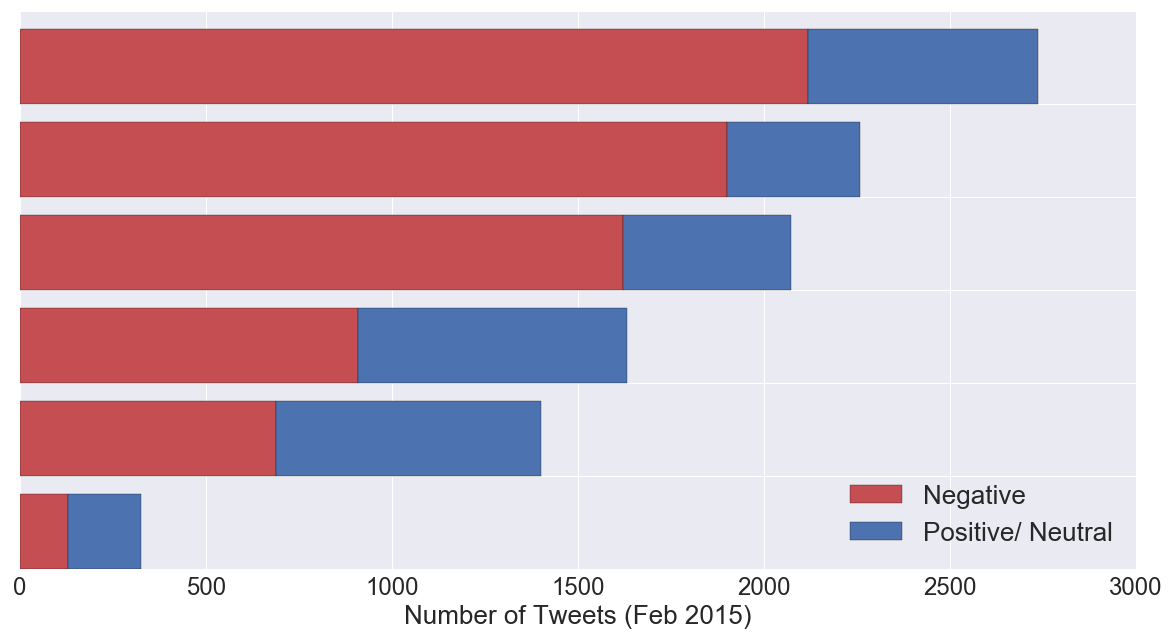

In [7]:
negative = cf_unambig.ix[cf_unambig.sentiment==1].groupby(by="airline", as_index=False)["_unit_id"].count()
positive = cf_unambig.ix[cf_unambig.sentiment==0].groupby(by="airline", as_index=False)["_unit_id"].count()

negative.rename(columns={"_unit_id":"negative_tweets"}, inplace=True)
positive.rename(columns={"_unit_id":"positive_tweets"}, inplace=True)
total = pd.merge(negative, positive, on="airline")
total["total_tweets"] = total.negative_tweets + total.positive_tweets
total.sort_values(by="total_tweets", ascending=True, inplace=True)
print total.airline.tolist()

blue = sns.color_palette("deep")[0]
red = sns.color_palette("deep")[2]

plt.figure(figsize=(20,10))
p1=plt.barh(np.arange(6), total.negative_tweets, 0.8, color=red, label="Negative")
p2=plt.barh(np.arange(6), total.positive_tweets, 0.8, color=blue, left=total.negative_tweets,label="Positive/ Neutral")

#plt.title("Tweets by Sentiment and Airline", fontsize=32)
plt.xlabel("Number of Tweets (Feb 2015)", fontsize=26)
#plt.yticks([(x+(0.75/2)) for x in range(0,6)],[])
plt.tick_params(axis="x", labelsize=24)
plt.tick_params(axis="y", colors="white")
plt.legend(loc="best", fontsize=26)
plt.savefig("graphics/twees_by_sentiment_airline.png")

#### Grid Search to Optimize Lexicon-Based Sentiment Analyzers

In [8]:
def lexicon_grid_search(variable, test, step):
    max_accuracy = 0
    max_param = np.nan
    
    for x in np.arange(-1, 1, step):
        pred_y = []
        
        for each in test[variable]:
            if each < x:
                pred_y.append(1) #negative
            else:
                pred_y.append(0) #positive/ neutral
            
        true_y = test["sentiment"]
        accuracy = accuracy_score(true_y, pred_y)
            
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_param = x
            
    return (max_param, max_accuracy)

print "Text Blob 0.5: "+str(lexicon_grid_search("text_blob_sentiment", cf_test, 0.5))
print "Text Blob 0.1: "+str(lexicon_grid_search("text_blob_sentiment", cf_test, 0.1))
print "Text Blob 0.05: "+str(lexicon_grid_search("text_blob_sentiment", cf_test, 0.05))
print ""
print "VADER 0.5: "+str(lexicon_grid_search("vader_sentiment", cf_test, 0.5))
print "VADER 0.1: "+str(lexicon_grid_search("vader_sentiment", cf_test, 0.1))
print "VADER 0.05: "+str(lexicon_grid_search("vader_sentiment", cf_test, 0.05))

Text Blob 0.5: (0.5, 0.73761585170981148)
Text Blob 0.1: (0.29999999999999982, 0.73761585170981148)
Text Blob 0.05: (0.40000000000000124, 0.74177053371684243)

VADER 0.5: (0.5, 0.75775007989773091)
VADER 0.1: (0.39999999999999969, 0.76478108021732183)
VADER 0.05: (0.3500000000000012, 0.76861617130073501)


The optimal TextBlob Sentiment Classifer attains a 77% accuracy on the test set.

#### Test Naive Bayes and SVM Models Trained on NLTK and Crowdflower Corpuses

#### Define Functions

In [9]:
air_travel_sws = ENGLISH_STOP_WORDS.union(["aa","united","usairways","americanair","southwestair","jetblue","http",\
                                           "virginamerica","amp","flight","flights","plane","gate","flightled",\
                                           "bag","airline","airport","fly"])

In [10]:
def fit_count_model(classifier, train, test, sws, binary):
    vectorizer = CountVectorizer(decode_error="ignore", ngram_range=(1,1), min_df=2, max_df=0.2, stop_words=sws,\
                                 tokenizer=tokenize, binary=binary)
    
    vectorizer.fit(train["text"])
    
    train_X = vectorizer.transform(train["text"])
    test_X = vectorizer.transform(test["text"])
    
    train_y = train["sentiment"]
    test_y = test["sentiment"]
    
    clf = classifier.fit(train_X, train_y)
    
    #print "Confusion Matrix: "
    #print confusion_matrix(test_y, clf.predict(test_X))
    
    accuracy = accuracy_score(test_y, clf.predict(test_X))
    features = zip(vectorizer.get_feature_names(), clf.coef_[0])
    top10_features = sorted(features, reverse=True, key=lambda x: x[1])[:10]
    
    print "Accuracy: "+str(accuracy)
    
    return [accuracy, [x[0] for x in top10_features]]
    

def fit_tfidf_model(classifier, train, test, sws, binary):
    vectorizer = TfidfVectorizer(decode_error="ignore", ngram_range=(1,1), min_df=2, max_df=0.2, stop_words=sws,
                                 tokenizer=tokenize, binary=binary)
        
    vectorizer.fit(train["text"])
    
    train_X = vectorizer.transform(train["text"])
    test_X = vectorizer.transform(test["text"])
    
    train_y = train["sentiment"]
    test_y = test["sentiment"]
    
    clf = classifier.fit(train_X, train_y)
    
    #print "Confusion Matrix: "
    #print confusion_matrix(test_y, clf.predict(test_X))
    
    accuracy = accuracy_score(test_y, clf.predict(test_X))
    features = zip(vectorizer.get_feature_names(), clf.coef_[0])
    top10_features=sorted(features, reverse=True, key=lambda x: x[1])[:10]
    
    print "Accuracy: "+str(accuracy)
    
    return [accuracy, [x[0] for x in top10_features]]


def test_models(function, train, sws, label):
    m1=function(BernoulliNB(binarize=None), train, cf_test, sws, True)
    m2=function(MultinomialNB(), train, cf_test, sws, False)
    m3=function(LinearSVC(), train, cf_test, sws, False)
    
    data = [{"clf":"Bernoulli NB", "accuracy":m1[0]*100, "features":m1[1], "label":label},\
            {"clf":"Multinomial NB", "accuracy":m2[0]*100, "features":m2[1], "label":label},\
            {"clf":"Linear SVM","accuracy":m3[0]*100, "features":m3[1], "label":label}]
    
    return pd.DataFrame(data)

In [11]:
general_count = test_models(fit_count_model, demo_tweets, "english", "General Tweets \n(Count Vectorized)")
print ""
general_tfidf = test_models(fit_tfidf_model, demo_tweets, "english", "General Tweets \n(TF-IDF Vectorized)")
print ""
airline_count = test_models(fit_count_model, cf_train, air_travel_sws, "Airline Tweets \n(Count Vectorized)")
print ""
airline_tfidf = test_models(fit_tfidf_model, cf_train, air_travel_sws, "Airline Tweets \n(TF-IDF Vectorized)")
print ""

results = pd.concat([general_count, general_tfidf, airline_count, airline_tfidf], axis=0)
results

Accuracy: 0.725151805689
Accuracy: 0.743368488335
Accuracy: 0.651006711409

Accuracy: 0.715244487057
Accuracy: 0.732821987856
Accuracy: 0.666027484819

Accuracy: 0.856184084372
Accuracy: 0.837647810802
Accuracy: 0.841482901886

Accuracy: 0.814956855225
Accuracy: 0.822946628316
Accuracy: 0.851390220518



,accuracy,clf,features,label
0,72.515181,Bernoulli NB,"[miss, just, want, like, sorry, time, love, kn...",General Tweets \n(Count Vectorized)
1,74.336849,Multinomial NB,"[miss, just, want, like, sorry, follow, time, ...",General Tweets \n(Count Vectorized)
2,65.100671,Linear SVM,"[letting, emotional, anybody, poorly, medicine...",General Tweets \n(Count Vectorized)
0,71.524449,Bernoulli NB,"[miss, want, sorry, just, like, love, know, fo...",General Tweets \n(TF-IDF Vectorized)
1,73.282199,Multinomial NB,"[miss, want, sorry, just, like, follow, love, ...",General Tweets \n(TF-IDF Vectorized)
2,66.602748,Linear SVM,"[shame, anybody, emotional, missing, justin, l...",General Tweets \n(TF-IDF Vectorized)
0,85.618408,Bernoulli NB,"[cancelled, service, hours, customer, hold, ti...",Airline Tweets \n(Count Vectorized)
1,83.764781,Multinomial NB,"[cancelled, service, hours, customer, hold, ti...",Airline Tweets \n(Count Vectorized)
2,84.148290,Linear SVM,"[denied, screwed, miserable, worse, dulles, br...",Airline Tweets \n(Count Vectorized)
0,81.495686,Bernoulli NB,"[cancelled, hours, service, hold, customer, de...",Airline Tweets \n(TF-IDF Vectorized)


#### Create Accuracy Graph

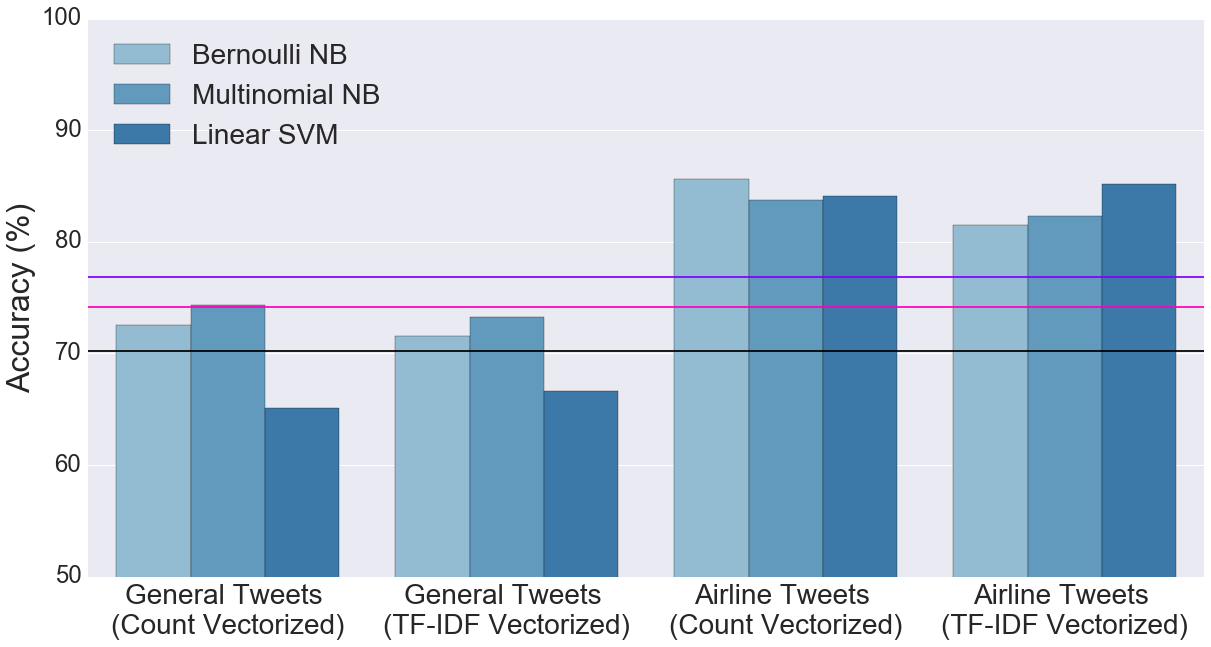

In [12]:
plt.figure(figsize=(20,10))

reds = sns.color_palette("Greens")[2:5]
blues = sns.color_palette("Blues")[2:5]

l1=plt.axhline(y=float(cf_test.sentiment.value_counts()[1]*100)/ cf_test.shape[0], color="black")
plt.axhline(y=lexicon_grid_search("text_blob_sentiment", cf_test, 0.05)[1]*100, color="#ff00bf")
plt.axhline(y=lexicon_grid_search("vader_sentiment", cf_test, 0.05)[1]*100, color="#8000ff")

sns.barplot(x="label", y="accuracy", hue="clf", palette=blues, data=results)

plt.xlabel("")
plt.ylabel("Accuracy (%)", fontsize=32)

plt.tick_params(axis="x", labelsize=28)
plt.tick_params(axis="y", labelsize=24)

plt.legend(loc="upper left", fontsize=28)

pylab.ylim([50,100])
plt.savefig("graphics/sentiment_analyzer_accuracy.png")

#### Look at Most Important Keywords

In [15]:
print results.columns

Index([u'accuracy', u'clf', u'features', u'label'], dtype='object')


In [16]:
def print_top_unigrams(df, clf, label):
    print clf, label
    
    for each in df.ix[(df["clf"]==clf) & (df["label"]==label)]["features"].tolist()[0]:
        print each

In [17]:
print_top_unigrams(results, "Bernoulli NB", "General Tweets \n(Count Vectorized)")
print_top_unigrams(results, "Bernoulli NB", "Airline Tweets \n(Count Vectorized)")

Bernoulli NB General Tweets 
(Count Vectorized)
miss
just
want
like
sorry
time
love
know
really
today
Bernoulli NB Airline Tweets 
(Count Vectorized)
cancelled
service
hours
customer
hold
time
just
delayed
help
hour
